<a href="https://colab.research.google.com/github/martin-dj/casa0018/blob/main/Week7/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

First set up the necessary Python imports and set up Tensor Board which provides a visual output of the training process.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt

# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard


# Clear any logs from previous runs
%rm -rf ./logs/

# Create Data

Create sine function data. We’ll use the NumPy linspace to generate x values ranging between 0 and 200*Pi (100 cycles) and NumPy sine function to generate sine values to the corresponding x. We subdivide the range into 1000 data points. We also add a linear componenent to the sine data to generate a trend.

We then add some noise to the data. Finally, we visualize the data.

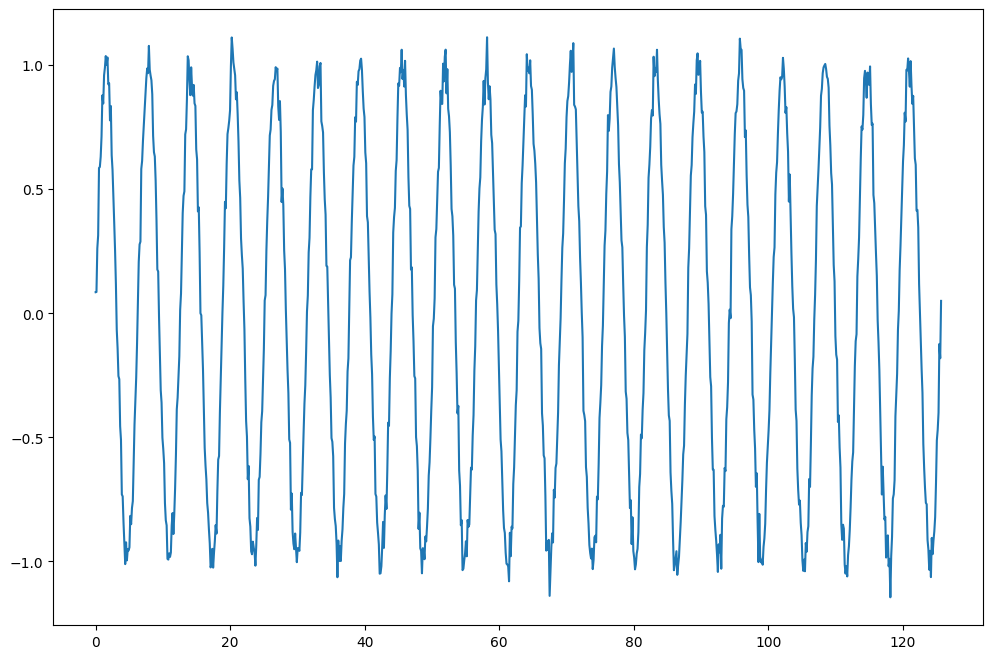

In [2]:
x = np.linspace(0, 20*2*np.pi, 1001) # in radians, 20 cycles, 50 data points per cycle
y = np.sin(x)
y += 0.05*np.random.randn(len(y)) #Add some noise to the data to make it more realistic
data = y
# Plot our data
plt.figure(figsize=(12,8))
plt.plot(x,y)
plt.show()


In [3]:
sequence_length = 50 # sequence length - the length of the training window
batch_size = 20

X = []
for i in range(len(data) - sequence_length):
    X.append(data[i : i + sequence_length])

X = np.array(X).reshape(-1, sequence_length, 1)  # Reshape for LSTM
print(len(X))

951


# Create a model

The code to create a LSTM is similar to that for earlier NNs you have already seen.

The variable (n_features) defined stands for the number of features in the training data i.e., as we are dealing with univariate data we’ll only have one feature whereas if we are using multivariate data containing multiple features then we must specify the count of features in our data.

In [4]:
n_features = 1

# Encoder
encoder = Sequential()
encoder.add(LSTM(sequence_length, activation="relu", return_sequences=False, input_shape=(sequence_length, n_features)))
encoder.add(RepeatVector(sequence_length)) # Repeat for decoder input

# Decoder
decoder = Sequential()
decoder.add(LSTM(sequence_length, activation="relu", return_sequences=True)) # Pass the output shape of the encoder
decoder.add(TimeDistributed(Dense(1)))

# Autoencoder
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 50, 1)               │          20,251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ==== Train Autoencoder on Normal Data ====
X_train = X[:int(0.8 * len(X))]  # Train on 80% of data
X_test = X[int(0.8 * len(X)):]

autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.4996 - val_loss: 0.4926
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.4717 - val_loss: 0.3691
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2974 - val_loss: 0.2864
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.2466 - val_loss: 0.0815
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0658 - val_loss: 0.0395
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0342 - val_loss: 0.0278
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0247 - val_loss: 0.0221
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0199 - val_loss: 0.0193
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0183 - val_loss: 0.0186
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0157 - val_loss: 0.0187
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0151 - val_loss: 0.0143
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.

# Comparing Predictions Using The Test Data

Now let's compare the predictions of the LSTM model using our test data set.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


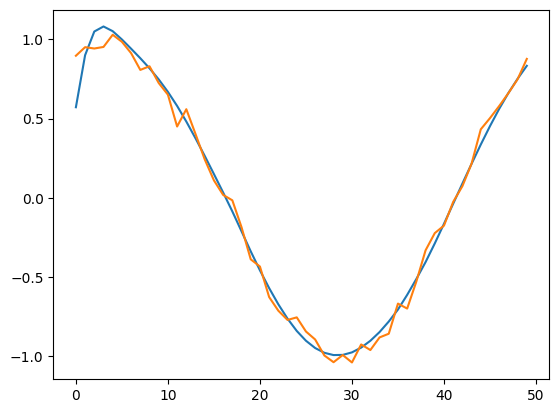

In [6]:
test = X_test[sequence_length-1: sequence_length]
current_pred = autoencoder.predict(test)
#print(current_pred)
# Select the first sequence from the batch and the first (and only) feature
plt.plot(current_pred[0, :, 0])
plt.plot(test[0, :, 0])

plt.show()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 50, 1)               │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.5933 - val_loss: 0.5140
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.5905 - val_loss: 0.5110
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.5873 - val_loss: 0.5077
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.5919 - val_loss: 0.5044
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.5813 - val_loss: 0.5065
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.5860 - val_loss: 0.4976
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.5594 - val_loss: 0.4254
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.4777 - val_loss: 0.4181
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.4287 - val_loss: 0.2388
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.2992 - val_loss: 0.1873
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.2356 - val_loss: 0.1147
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1

ValueError: x and y can be no greater than 2D, but have shapes (1450,) and (1450, 50, 1)

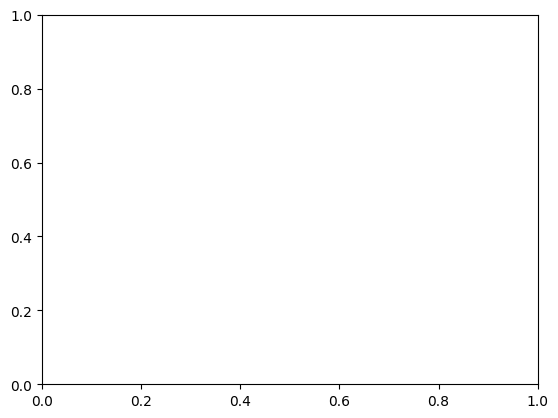

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt

# ==== Generate Sinusoidal Data with Anomalies ====
def generate_sinusoidal_data(samples=1500, time_steps=50, frequency=0.1, noise=0.02, anomaly_ratio=0.05):
    """Generates a sinusoidal time series with injected anomalies"""
    t = np.linspace(0, samples * frequency, samples)
    data = np.sin(2 * np.pi * t) + noise * np.random.randn(len(t))  # Sine wave with noise

    # Inject anomalies (random spikes)
    num_anomalies = int(samples * anomaly_ratio)
    anomaly_indices = np.random.choice(samples, num_anomalies, replace=False)
    data[anomaly_indices] += np.random.uniform(-2, 2, num_anomalies)  # Add large spikes

    return data

# Generate Data
time_steps = 50
num_samples = 1500
data = generate_sinusoidal_data(num_samples)

# Create Sliding Window Data
def create_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
    return np.array(X).reshape(-1, time_steps, 1)  # Reshape for LSTM

X = create_sequences(data, time_steps)

# ==== Define LSTM Autoencoder ====
latent_dim = 50

# Encoder
inputs = Input(shape=(time_steps, 1))
encoded = LSTM(latent_dim, activation="relu", return_sequences=False)(inputs)
encoded = RepeatVector(time_steps)(encoded)  # Repeat for decoder input

# Decoder
decoded = LSTM(latent_dim, activation="relu", return_sequences=True)(encoded)
decoded = TimeDistributed(Dense(1))(decoded)  # TimeDistributed for sequence output

# Define Autoencoder Model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# ==== Train Autoencoder on Normal Data ====
X_train = X[:int(0.8 * len(X))]  # Train on 80% of data
autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, validation_split=0.1)

# ==== Anomaly Detection ====
X_pred = autoencoder.predict(X)  # Reconstruct sequences
plt.plot(X_pred)
reconstruction_errors = np.mean(np.abs(X - X_pred), axis=(1, 2))  # Compute reconstruction error per sequence

# Set Anomaly Threshold (e.g., 95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold  # Flag anomalies

# ==== Plot Results ====
plt.figure(figsize=(10, 4))
plt.plot(range(len(data)), data, label="Original Data")
plt.scatter(np.where(anomalies)[0] + time_steps, data[time_steps:][anomalies], color="red", label="Anomalies")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Anomaly Detection in Sinusoidal Time Series")
plt.show()
